Modèle avec **Transformer T5** Dans cette seconde partie je vais réaliser un modèle à base de Tranformers

In [ ]:
 #Importation des librairies
! pip install Sentencepiece
! pip install transformers

     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 4.0 MB 4.7 MB/s 
     |████████████████████████████████| 6.5 MB 24.7 MB/s 
     |████████████████████████████████| 895 kB 48.7 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 60.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
! nvidia-smi

Mon Apr 11 10:19:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf

from nltk.tokenize import RegexpTokenizer
import nltk

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)

In [ ]:
#Fonction qui supprime le tag si celui ci n'appartient au TOP        
def removeNotTop100(Word_list,Top100):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word not in Top100: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    if len(filtered_Word_list) == 0:
        return None
    else:
        return filtered_Word_list

In [ ]:
# Google Drive connexion
from google.colab import drive
drive.mount('/content/drive')

#Lecture du Fichier
df_init = pd.read_csv('/content/drive/MyDrive/FORMATION/P8/QueryResultsFull.csv', sep = ',', encoding='UTF-8')

Mounted at /content/drive


In [ ]:
df_init.head(1)

,Id,BODY,Title,Tags,CreationDate
0,2293498,<p>I've written a Git post-commit hook and it ...,Applying a git post-commit hook to all current...,<git><hook><githooks>,2010-02-19 01:24:42


In [ ]:
#df["BODY"] = df["BODY"].str.lower()
#df["Tags"] = df["Tags"].str.lower()
#df["Title"] = df["Title"].str.lower()
df_init["TitleBody"] = df_init["Title"] + " " + df_init["BODY"]
df_init["TitleBody"] = df_init["TitleBody"].str.lower()

In [ ]:
#Expression régulière pour prendre uniquement les valeurs entre <>
tokenizer = RegexpTokenizer('(?<=\<).*?(?=\>)')

#Création de la colonne avec ces valeurs
df_init['tags_words'] = df_init.apply(lambda row: tokenizer.tokenize(row['Tags']), axis=1)

#Comptage de l'utlisation des mots
Top_Word = nltk.FreqDist()
Top100 = []
for x in df_init['tags_words']:
    Top_Word += nltk.FreqDist(x)

for i in Top_Word.most_common()[0:100]:
    Top100.append(i[0])
    
#Suppression des Tags qui ne sont pas dans le TOP
df_init['processed_tags_final'] = df_init.apply(lambda row:removeNotTop100(row['tags_words'],Top100), axis=1)

#Suppression des lignes sans Tags
df_init = df_init.dropna()

In [ ]:
df_init.head(1)

,Id,BODY,Title,Tags,CreationDate,TitleBody,tags_words,processed_tags_final
0,2293498,<p>I've written a Git post-commit hook and it ...,Applying a git post-commit hook to all current...,<git><hook><githooks>,2010-02-19 01:24:42,applying a git post-commit hook to all current...,"[git, hook, githooks]",[git]


**ONE HOT ENCODER** sur les étiquettes de sortie
Utilisation de la librairie MultilabelBinarizer de SKLEARN

Création de la variable Labels

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

#Création des étiquettes de sorties
Labels = pd.DataFrame(mlb.fit_transform(df_init['processed_tags_final']),
                   columns=mlb.classes_,
                   index=df_init['processed_tags_final'].index)

In [ ]:
print(df_init.shape)

(44920, 8)


In [ ]:
train_df  = pd.concat([df_init.loc[:,['Title','TitleBody']], Labels], axis = 1)

In [ ]:
#Création d'un Dataframe de test
test_df = train_df.iloc[-2000:]

train_df = train_df.iloc[0:len(train_df)-2000,:]


print(train_df.shape)
print(test_df.shape)
#train_df= train_df.iloc[:100,:]

(42920, 102)
(2000, 102)


In [ ]:
train_df.head(5)

,Title,TitleBody,.net,ajax,algorithm,android,android-studio,angular,angularjs,arrays,...,unit-testing,unix,version-control,vim,visual-studio,windows,winforms,wpf,xcode,xml
0,Applying a git post-commit hook to all current...,applying a git post-commit hook to all current...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CSS: fixed to bottom and centered,css: fixed to bottom and centered <p>i need my...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Can I serialize a C# Type object?,can i serialize a c# type object? <p>i'm tryin...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Pretty printing XML files on Emacs,pretty printing xml files on emacs <p>i use em...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,What do the different brackets in Ruby mean?,what do the different brackets in ruby mean? <...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# preprocessing
def clean_abstract(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text
    

def get_texts(df):
    texts = 'multilabel classification: ' + df['TitleBody'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts


def get_labels(df):
    labels_li = [' '.join(x.lower().split()) for x in df.columns.to_list()[3:]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, 3:].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append(' , '.join(x.tolist()) + ' </s>')
        else:
            labels.append('none </s>')
    return labels

texts = get_texts(train_df)
labels = get_labels(train_df)

for text, label in zip(texts[:5], labels[:5]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

TEXT -	multilabel classification: applying a git post-commit hook to all current and future repositories <p>i've written a git post-commit hook and it works correctly .  however ,  i want to add this hook to apply to all current  ( and future )  git repositories i am working on .  i tried adding the hook to my <code>~/ . git/hooks/</code> directory instead of in the hooks directory in the project directory ,  however ,  this did not seem to work . </p> <p>is there a way to create global git hooks that will apply to all repositories on my system  ( without having to copy them into each project directory )  ?  if not ,  what would be the best solution going forward -- perhaps a git-init template ? </p>
LABEL -	git </s>

TEXT -	multilabel classification: css: fixed to bottom and centered <p>i need my footer to be fixed to the bottom of the page and to center it .  the contents of the footer may change at all time so i can't just center it via margin-left: xxpx; margin-right: xxpx;</p> <p>

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 't5-base'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 80
        self.TGT_MAX_LENGTH = 20
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 6

config = Config()

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

In [ ]:
# train-val split

np.random.seed(config.SEED)

dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(config.VALIDATION_SPLIT * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
train_data = T5Dataset(train_df, train_indices)
val_data = T5Dataset(train_df, val_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([16, 80])
src_attention_mask shape: torch.Size([16, 80])
tgt_input_ids shape: torch.Size([16, 20])
tgt_attention_mask shape: torch.Size([16, 20])


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

In [ ]:
device = config.DEVICE
device

device(type='cuda')

Fonction pour décoder le labels et renvoyer du text
**get_ohe**


In [ ]:
# the get_ohe fonction convertit les elements binaires en libellés textuel -
# - cela afin de permettre de calculer le F1 Score
# Ajout d'un traitement pour supprimer les pad et le /s

def get_ohe(x):
    labels_li = ['_'.join(x.lower().split()) for x in train_df.columns.to_list()[3:]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx
    
    y = [labels.split(', ') for labels in x]

    ohe = []
    for labels in y:
        temp = [0] * len(labels_li)
        for label in labels:

            label = label.replace("<pad>","")
            label = label.replace("</s>","")
            label = label.strip()

            idx = labels_li_indices.get(label.strip(), -1)
            if idx != -1:
                temp[idx] = 1
        ohe.append(temp)
    ohe = np.array(ohe)
    return ohe



In [ ]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        labels = b_tgt_input_ids.to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                labels=labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs.loss

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(true_ohe, pred_ohe)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', val_accuracy)

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score, avg_val_loss, val_accuracy


def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    resultat = []
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
   
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        labels = batch['tgt_input_ids'].to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100
    
        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()
        
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        labels=labels,
                        decoder_attention_mask=b_tgt_attention_mask)
    

        loss = outputs.loss
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss) 

In [ ]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    resultat = []
    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        resultat.append(val(model, val_dataloader, criterion))
        val_micro_f1_score = resultat[epoch][0]

        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_micro_f1_score} -> {val_micro_f1_score}')
                max_val_micro_f1_score = val_micro_f1_score

    return best_model, best_val_micro_f1_score,resultat 

In [ ]:
model = T5Model()
model.to(device);

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
best_model, best_val_micro_f1_score, resultat = run()

Epoch 0:   0%|          | 0/2012 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 600
Val loss: 0.6805274560714443
Val accuracy: 0.32907735321528425
Val micro f1 score: 0.538734644606973


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1200
Val loss: 0.562416502820042
Val accuracy: 0.3579683131407269
Val micro f1 score: 0.5827396702625688


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1800
Val loss: 0.5077466565654815
Val accuracy: 0.3860205032618826
Val micro f1 score: 0.6123333333333333


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Training loss: 0.790988123322102
Val loss: 0.4982038263547971
Val accuracy: 0.3874184529356943
Val micro f1 score: 0.6158259149357073
--- Best Model. Val loss: -inf -> 0.6158259149357073


Epoch 1:   0%|          | 0/2012 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 600
Val loss: 0.4686229992019437
Val accuracy: 0.4063373718546132
Val micro f1 score: 0.6333922840112661


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1200
Val loss: 0.44998927434403924
Val accuracy: 0.41491146318732525
Val micro f1 score: 0.6428525247300704


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1800
Val loss: 0.4372650054679009
Val accuracy: 0.4272134203168686
Val micro f1 score: 0.6610014215763703


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Training loss: 0.5216232790698706
Val loss: 0.42902850889324606
Val accuracy: 0.4266542404473439
Val micro f1 score: 0.6592440480010269
--- Best Model. Val loss: 0.6158259149357073 -> 0.6592440480010269


Epoch 2:   0%|          | 0/2012 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 600
Val loss: 0.4208228860366895
Val accuracy: 0.43066169617893757
Val micro f1 score: 0.664905468202941


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1200
Val loss: 0.41409008757901083
Val accuracy: 0.43727865796831317
Val micro f1 score: 0.6693125892998888


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1800
Val loss: 0.40667676619197146
Val accuracy: 0.44305684995340167
Val micro f1 score: 0.6802938960060286


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Training loss: 0.4632522819071238
Val loss: 0.40113344499855214
Val accuracy: 0.443336439888164
Val micro f1 score: 0.6786105803865068
--- Best Model. Val loss: 0.6592440480010269 -> 0.6786105803865068


Epoch 3:   0%|          | 0/2012 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 600
Val loss: 0.4008451495458401
Val accuracy: 0.4463187325256291
Val micro f1 score: 0.680556864963389


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1200
Val loss: 0.3944849871576454
Val accuracy: 0.45069897483690585
Val micro f1 score: 0.682643427741467


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1800
Val loss: 0.39508384775964406
Val accuracy: 0.4540540540540541
Val micro f1 score: 0.6884741075917546


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Training loss: 0.4269332573721352
Val loss: 0.3890876478214378
Val accuracy: 0.45675675675675675
Val micro f1 score: 0.6896616956206452
--- Best Model. Val loss: 0.6786105803865068 -> 0.6896616956206452


Epoch 4:   0%|          | 0/2012 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 600
Val loss: 0.38629856072754865
Val accuracy: 0.4600186393289842
Val micro f1 score: 0.6924575738529227


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1200
Val loss: 0.3837398294631486
Val accuracy: 0.4592730661696179
Val micro f1 score: 0.6917982359772749


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1800
Val loss: 0.38622971724069244
Val accuracy: 0.4614165890027959
Val micro f1 score: 0.6937631835783774


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Training loss: 0.40894775436246844
Val loss: 0.38304568012140905
Val accuracy: 0.46262814538676605
Val micro f1 score: 0.6954714366693959
--- Best Model. Val loss: 0.6896616956206452 -> 0.6954714366693959


Epoch 5:   0%|          | 0/2012 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 600
Val loss: 0.3820832193386359
Val accuracy: 0.46561043802423113
Val micro f1 score: 0.697804441373245


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1200
Val loss: 0.38057872097822665
Val accuracy: 0.46514445479962724
Val micro f1 score: 0.6954193182534182


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


-- Step: 1800
Val loss: 0.3817169637309634
Val accuracy: 0.4666356011183597
Val micro f1 score: 0.6958034217766673


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Training loss: 0.3959570268676366
Val loss: 0.38127065187905834
Val accuracy: 0.4668219944082013
Val micro f1 score: 0.6961409713888713
--- Best Model. Val loss: 0.6954714366693959 -> 0.6961409713888713


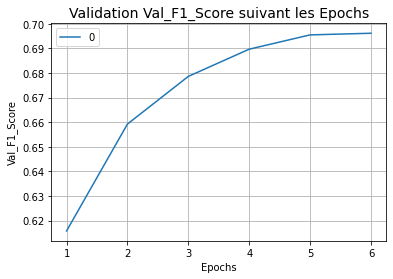

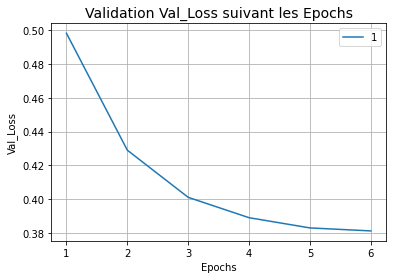

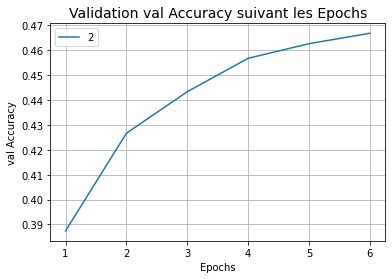

In [ ]:
def plot_result(item,label):
    plt.plot(range(1,len(resultat)+1),np.array(resultat).T[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.title("Validation {} suivant les Epochs".format(label), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result(0,"Val_F1_Score")
plot_result(1,"Val_Loss")
plot_result(2,"val Accuracy")

In [ ]:
dataset_size = len(test_df)
test_indices = list(range(dataset_size))

test_data = T5Dataset(test_df, test_indices)
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

In [ ]:
import collections
def predict(model):
    
    true, pred = [], []
    erreurs = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        b_tgt_input_ids = batch['tgt_input_ids']
        labels = b_tgt_input_ids.to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        with torch.no_grad():
            
            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)
            
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )


            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

           
    
    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)
    print('Accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Micro f1 score:', val_micro_f1_score)

    
    #Affiche de 5 prédiction
    for i in range(0,5):
      print("Etiquette(s) réelle(s)",true[i].replace("<pad>",""))
      print("Prédiction des étiquettes",pred[i].replace("<pad>",""))
    
    #Recupération des erreurs
    for x in range(0,len(true_ohe)):
      if collections.Counter(true_ohe[x]) != collections.Counter(pred_ohe[x]):
        erreurs.append(true[x].replace("<pad>",""))
        erreurs.append(pred[x].replace("<pad>",""))

    return pred_ohe,erreurs

pred_ohe, erreurs = predict(best_model)


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:195: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


Accuracy: 0.5005
Micro f1 score: 0.7125450489102455
Etiquette(s) réelle(s) datetime, mysql</s>           
Prédiction des étiquettes  datetime, mysql</s>
Etiquette(s) réelle(s) docker</s>                 
Prédiction des étiquettes  docker</s>      
Etiquette(s) réelle(s) git</s>                 
Prédiction des étiquettes  git</s>      
Etiquette(s) réelle(s) php</s>                 
Prédiction des étiquettes  php</s>      
Etiquette(s) réelle(s) windows</s>                  
Prédiction des étiquettes  windows</s>       
